<a href="https://colab.research.google.com/github/Rakesh8086/Road-network-extraction/blob/main/U_net_self_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import os

class CustomDataGenerator(Sequence):
    def __init__(self, image_dir, mask_dir=None, batch_size=32, target_size=(256, 256), shuffle=True):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.image_filenames = os.listdir(image_dir)

        if mask_dir:
            self.mask_filenames = os.listdir(mask_dir)
            assert len(self.image_filenames) == len(self.mask_filenames), "Number of images and masks must match."
        else:
            self.mask_filenames = None

        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_filenames) / self.batch_size))

    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError('DataGenerator object is out of range')
        batch_images = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        return self.__data_generation(batch_images)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_filenames)

    def __data_generation(self, batch_images):
        X = np.empty((self.batch_size, *self.target_size, 3))  # Satellite images with 3 channels (RGB)
        if self.mask_dir:
            y = np.empty((self.batch_size, *self.target_size, 1))  # Masks converted to 1 channel
        else:
            y = None

        for i, image_name in enumerate(batch_images):
            # Load and preprocess satellite image (RGB)
            img_path = os.path.join(self.image_dir, image_name)
            image = load_img(img_path, target_size=self.target_size)  # Default is RGB
            X[i,] = img_to_array(image) / 255.0  # Normalize to [0, 1]

            # Load and preprocess mask image (convert RGB to grayscale)
            if self.mask_dir:
                mask_name = image_name.replace('_sat.jpg', '_mask.png')
                mask_path = os.path.join(self.mask_dir, mask_name)
                mask = load_img(mask_path, target_size=self.target_size, color_mode='grayscale')  # Load mask as grayscale
                y[i,] = img_to_array(mask) / 255.0

        return X, y

In [ ]:
train_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/road-extraction-DL/updated-data/train_resize/satellite_resize',
    mask_dir='/content/drive/MyDrive/road-extraction-DL/updated-data/train_resize/mask_resize'
)

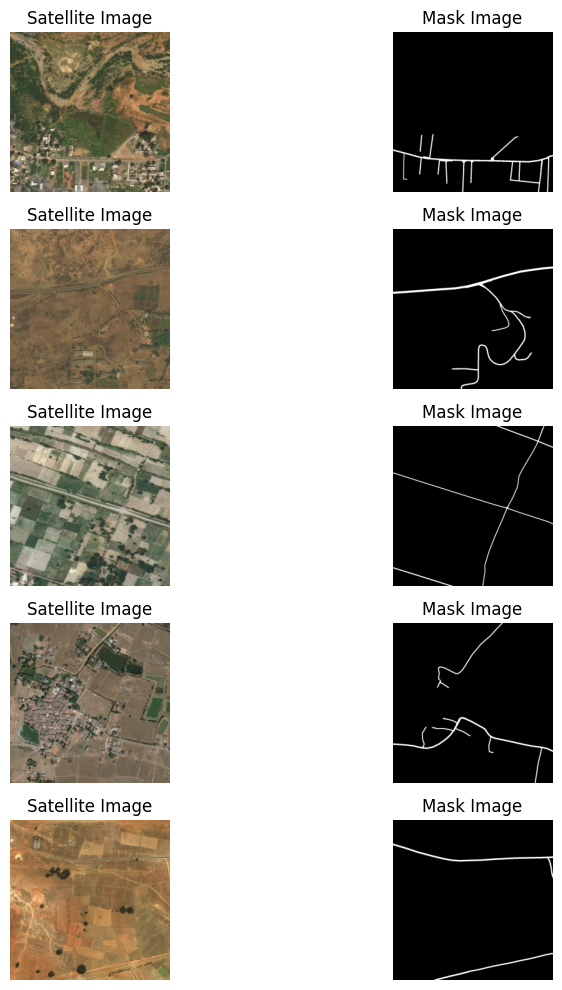

In [ ]:
import matplotlib.pyplot as plt

satellite_images, masks = train_gen[0]  # Get first bactch

num_images = 5

fig, axes = plt.subplots(num_images, 2, figsize=(10, num_images * 2))

for i in range(num_images):
    # Display satellite image
    axes[i, 0].imshow(satellite_images[i])
    axes[i, 0].set_title('Satellite Image')
    axes[i, 0].axis('off')

    # Display mask image
    axes[i, 1].imshow(masks[i].squeeze(), cmap='gray')  # Squeeze to remove single-dimensional entries
    axes[i, 1].set_title('Mask Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
total_batches = len(train_gen)
print(f"Total batches in train_gen: {total_batches}")

Total batches in train_gen: 175


In [ ]:
val_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/road-extraction-DL/updated-data/validation_resize/validation_satellite_resize',
    mask_dir='/content/drive/MyDrive/road-extraction-DL/updated-data/validation_resize/validation_mask_resize'
)

In [ ]:
total_batches = len(val_gen)
print(f"Total batches in val_gen: {total_batches}")

Total batches in val_gen: 19


In [ ]:
test_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/road-extraction-DL/updated-data/test_resize'
)

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

In [ ]:
import tensorflow as tf

def self_attention_block(x, filters):
    # 1x1 convolutions for query, key, and value
    q = Conv2D(filters // 8, (1, 1), padding="same")(x)  # Query
    k = Conv2D(filters // 8, (1, 1), padding="same")(x)  # Key
    v = Conv2D(filters, (1, 1), padding="same")(x)       # Value

    # Compute attention score
    attention = tf.matmul(tf.reshape(q, [tf.shape(x)[0], -1, filters // 8]),
                          tf.reshape(k, [tf.shape(x)[0], -1, filters // 8]), transpose_b=True)

    # Apply softmax to get attention weights
    attention = tf.nn.softmax(attention, axis=-1)

    # Apply attention to the value matrix
    attention_output = tf.matmul(attention, tf.reshape(v, [tf.shape(x)[0], -1, filters]))

    # Reshape back to the original shape of x
    attention_output = tf.reshape(attention_output, tf.shape(x))

    # Add the attention output to the original input (residual connection)
    output = tf.add(attention_output, x)

    return output

In [ ]:
def binary_unet_with_self_attention(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    # Input layer
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Downsampling layers
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1) # 128*128 now

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2) # 64*64 now

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3) # 32*32 now

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4) # 16*16 now

    # Bottleneck with self-attention
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Apply self-attention
    c5 = self_attention_block(c5, filters=256) # at 16*16 featue map

    # Upsampling layers
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4]) # 32*32 now
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3]) # 64*64 now
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2]) # 128*128 now
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1]) # 226*256 now
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model = binary_unet_with_self_attention(IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)
model.summary()

ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save at every epoch
checkpoint_callback = ModelCheckpoint(
    '/content/drive/MyDrive/road-extraction-DL/updated-data/epoch_{epoch:02d}_self_attention_model.keras',  # Saving with epoch in the filename
    monitor='val_loss',  # Still monitoring validation loss, but saving at every epoch
    save_best_only=False,  # Save the model at every epoch, not just the best
    mode='min',
    verbose=1
)


In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    epochs=10,
    verbose=1,
    callbacks=[checkpoint_callback]
)

Epoch 1/10
175/175 [==============================] - ETA: 0s - loss: 0.2061 - accuracy: 0.9251 
Epoch 1: saving model to /content/drive/MyDrive/road-extraction-DL/updated-data/epoch_01_self_attention_model.keras
175/175 [==============================] - 2904s 17s/step - loss: 0.2061 - accuracy: 0.9251 - val_loss: 0.1569 - val_accuracy: 0.9441
Epoch 2/10
175/175 [==============================] - ETA: 0s - loss: 0.1503 - accuracy: 0.9450
Epoch 2: saving model to /content/drive/MyDrive/road-extraction-DL/updated-data/epoch_02_self_attention_model.keras
175/175 [==============================] - 536s 3s/step - loss: 0.1503 - accuracy: 0.9450 - val_loss: 0.1508 - val_accuracy: 0.9445
Epoch 3/10
175/175 [==============================] - ETA: 0s - loss: 0.1429 - accuracy: 0.9450
Epoch 3: saving model to /content/drive/MyDrive/road-extraction-DL/updated-data/epoch_03_self_attention_model.keras
175/175 [==============================] - 531s 3s/step - loss: 0.1429 - accuracy: 0.9450 - val_l

In [ ]:
model.save('/content/drive/MyDrive/road-extraction-DL/updated-data/validation_resize/u_netself_attention_best_model.keras')

In [ ]:
test_gen = CustomDataGenerator(
    image_dir='/content/drive/MyDrive/road-extraction-DL/updated-data/test_resize',
    mask_dir=None,  # Masks are not needed for testing
    batch_size=1,
    target_size=(256, 256),
    shuffle=False
)

In [ ]:
predictions = model.predict(test_gen)

1101/1101 [==============================] - 49s 44ms/step


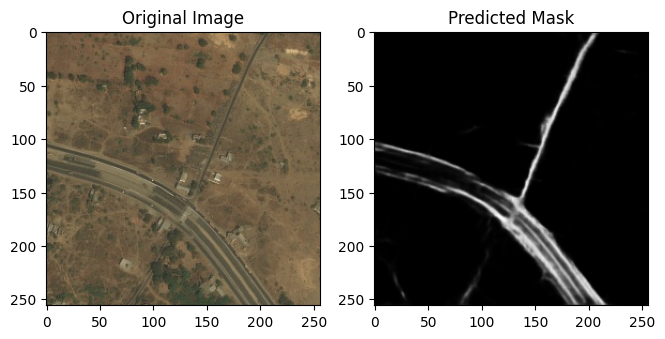

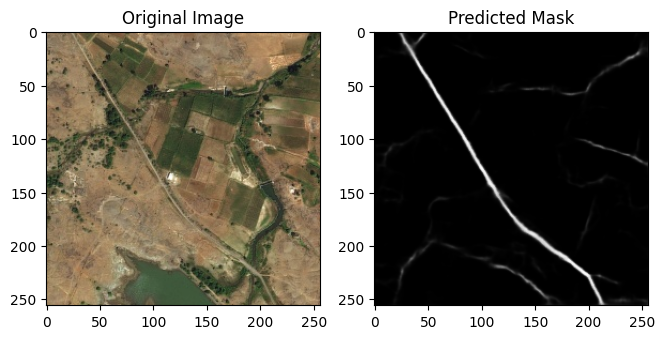

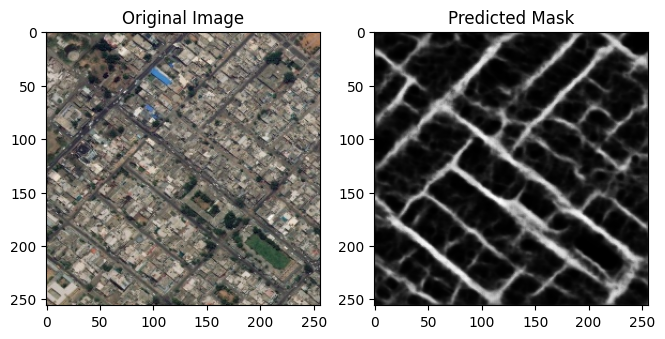

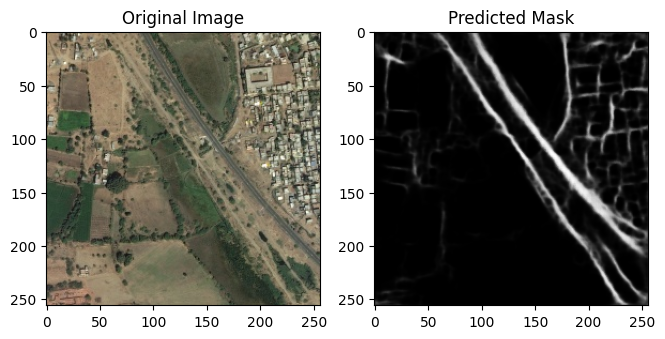

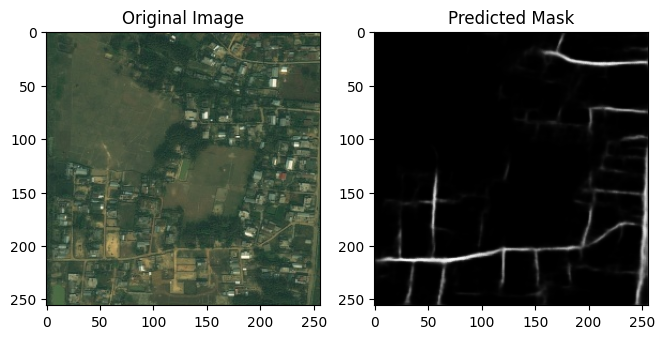

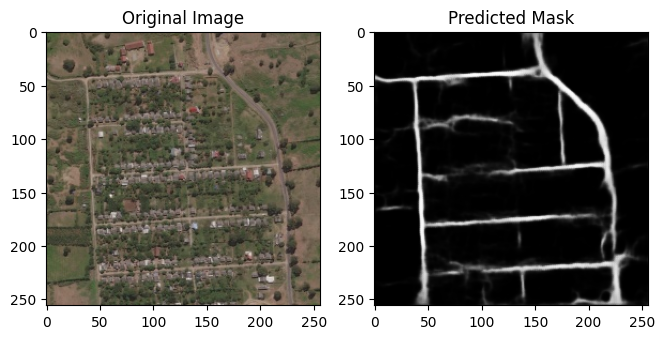

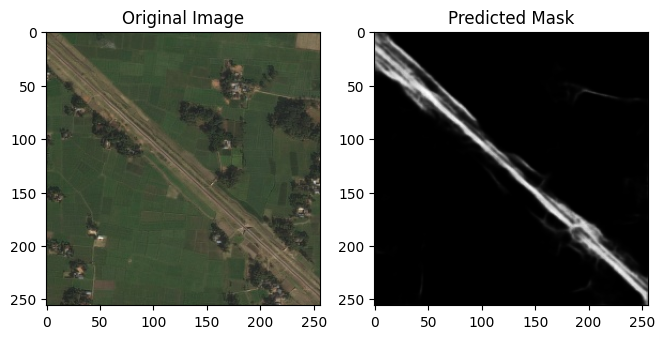

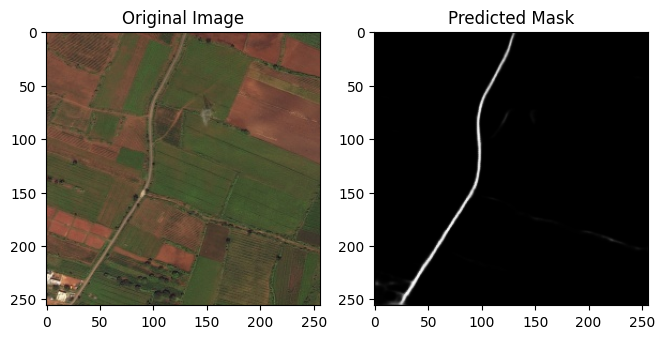

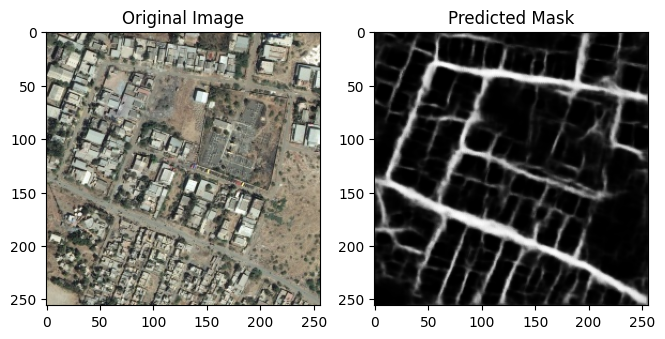

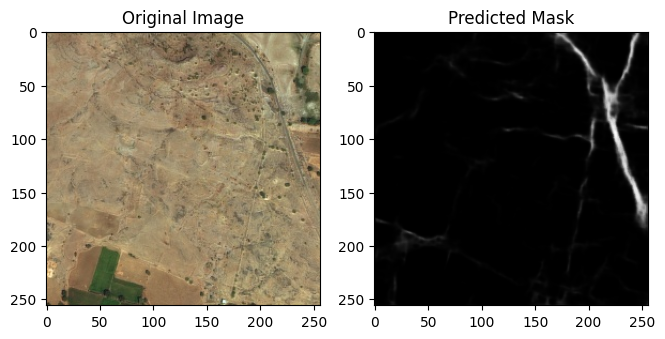

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize some predictions
num_images_to_show = 10  # Adjust as needed

for i in range(num_images_to_show):
    plt.figure(figsize=(12, 6))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(test_gen[i][0][0])  # Get the first test image
    plt.title('Original Image')

    # Predicted Mask
    plt.subplot(1, 3, 2)
    plt.imshow(predictions[i].squeeze(), cmap='gray')  # Squeeze to remove channels if needed
    plt.title('Predicted Mask')

    plt.show()

In [ ]:
test_images_dir = '/content/drive/MyDrive/road-extraction-DL/updated-data/new_images'
# Prepare to store predictions
predictions = []

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from PIL import Image

count = 0
# Loop through each image in the directory
for image_name in os.listdir(test_images_dir):
    if count == 1:
      break
    img_path = os.path.join(test_images_dir, image_name)

    # Load and preprocess the image
    with Image.open(img_path) as img:
        img_resized = img.resize((256, 256))
        img_array = np.array(img_resized) / 255.0

        # Check if the image has 3 channels (RGB)
        if img_array.shape[-1] == 3:
            img_array = np.expand_dims(img_array, axis=0)

            # Make prediction
            prediction = model.predict(img_array)
            predictions.append(prediction[0])  # Store the prediction (removing batch dimension)
        else:
            print(f"Image {image_name} does not have 3 channels. Skipping...")

        count += 1

# Convert predictions to binary masks
binary_masks = [(pred > 0.5).astype(np.uint8) for pred in predictions]

# Save the predicted masks
output_masks_dir = '/content/drive/MyDrive/road-extraction-DL/updated-data/new_images_resize'
os.makedirs(output_masks_dir, exist_ok=True)

for i, mask in enumerate(binary_masks):
    mask = np.squeeze(mask)  # Remove unnecessary dimensions if any

    # If the mask still has 3 dimensions, take only the first channel
    if len(mask.shape) == 3:
        mask = mask[:, :, 0] # Select the first channel of the mask

    mask_image = Image.fromarray(mask.astype(np.uint8) * 255, mode='L')  # mode='L' ensures a grayscale image
    mask_image.save(os.path.join(output_masks_dir, f"crack_predicted_mask_{i}.png"))

print("Predictions have been made and saved.")

NameError: name 'model' is not defined

In [ ]:
################## Test images ######################

In [ ]:
import os
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
import matplotlib.pyplot as plt

test_image_dir = '/content/drive/MyDrive/road-extraction-DL/updated-data/test_resize'
save_dir = '/content/drive/MyDrive/road-extraction-DL/updated-data/predicted_mask_U-net-self-attention'

os.makedirs(save_dir, exist_ok=True)

test_images = os.listdir(test_image_dir)

for image_name in test_images:
    img_path = os.path.join(test_image_dir, image_name)
    image = load_img(img_path, target_size=(256, 256))
    image_array = img_to_array(image) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # Make prediction
    prediction = model.predict(image_array)

    # Process prediction to binary mask (thresholding)
    predicted_mask = (prediction.squeeze() > 0.5).astype(np.uint8)  # Binarize the prediction

    mask_save_path = os.path.join(save_dir, f'predicted_mask_{image_name}')
    plt.imsave(mask_save_path, predicted_mask, cmap='gray')  # Save as grayscale image

print("Predictions saved successfully!")


1/1 [==============================] - 0s 52ms/step
Predictions saved successfully!
